In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch


from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from lnn_model import JetParticleDataset_ltc, BinaryClassificationLTC
from utils import count_parameters, plot_metrics, plot_ROC, calculate_rocs, plot_ROC_all

from time import time
import gc

In [3]:
print('Preparing data...')
start = time()
        
N = 16         
reverse = ''#'_reversed'
file_path = f'/home/asugu/work/event_data_tt_pad{N}_4mom{reverse}.pkl'

from_checkpoint = True
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_100.pth'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()


Preparing data...


20

In [4]:


device =  torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  
print(device)

batch_size = 2048
n_epochs = 1
learning_rate = 0.01

in_features = 11
out_features = 1
hidden_units = 24
sparsity = 0.3


cuda:1


alloc!
+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     ltc_cell.rnn_cell.gleak     |     24     |
|     ltc_cell.rnn_cell.vleak     |     24     |
|       ltc_cell.rnn_cell.cm      |     24     |
|     ltc_cell.rnn_cell.sigma     |    576     |
|       ltc_cell.rnn_cell.mu      |    576     |
|       ltc_cell.rnn_cell.w       |    576     |
|      ltc_cell.rnn_cell.erev     |    576     |
| ltc_cell.rnn_cell.sensory_sigma |    264     |
|   ltc_cell.rnn_cell.sensory_mu  |    264     |
|   ltc_cell.rnn_cell.sensory_w   |    264     |
|  ltc_cell.rnn_cell.sensory_erev |    264     |
|    ltc_cell.rnn_cell.input_w    |     11     |
|    ltc_cell.rnn_cell.input_b    |     11     |
|    ltc_cell.rnn_cell.output_w   |     1      |
|    ltc_cell.rnn_cell.output_b   |     1      |
|           fc_1.weight           |    128     |
|            fc_1.bias            |     8      |
|           f

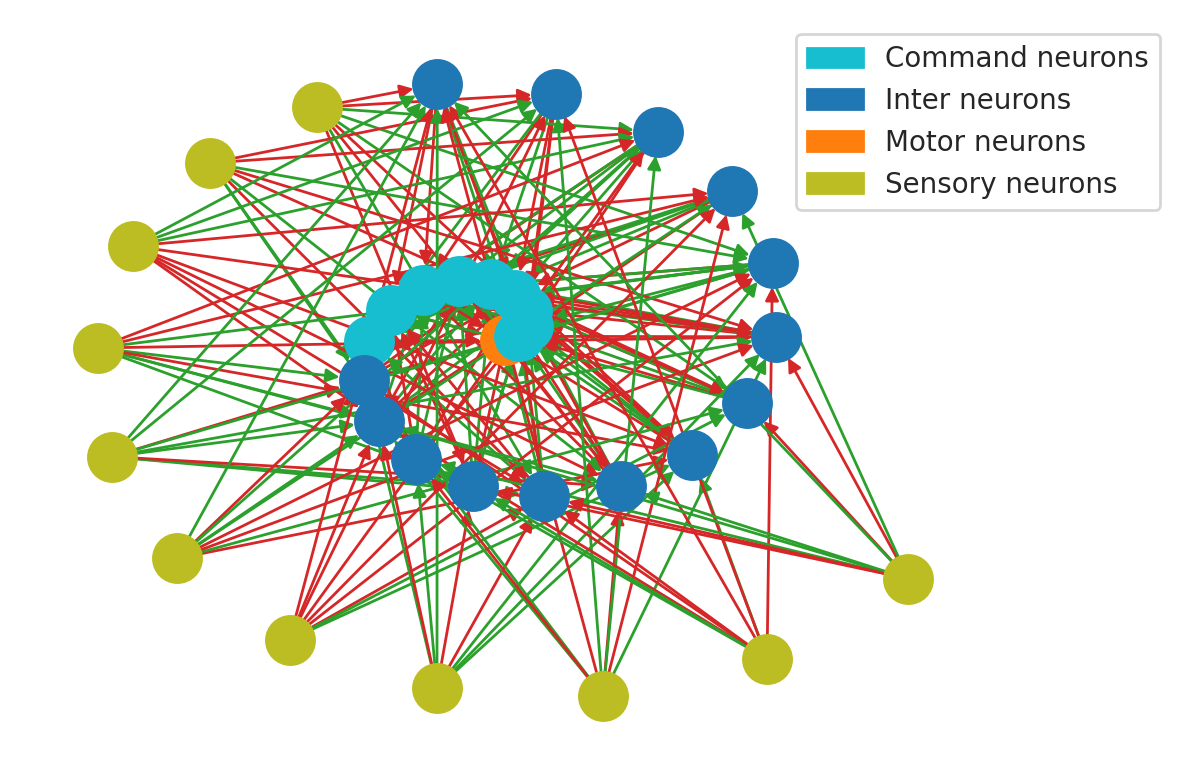

scalr is : (array([-0.125]), array([0.59947894]))


In [5]:

model = BinaryClassificationLTC(in_features,units=hidden_units, seq_len=N, sparsity=sparsity)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

else:
    epoch = 0 
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_train_auc = []
    epoch_train_f1 = []
    epoch_val_loss = []
    epoch_val_accuracy = []
    epoch_val_auc = []
    epoch_val_f1 = []
    scaler = StandardScaler()
model.to(device)

count_parameters(model)

model.print_model()

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

print("scalr is :", scaler)


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['btag'])



train_dataset = JetParticleDataset_ltc(train_df, device=device, eval=False,scaler=scaler,checkpoint=from_checkpoint)
test_dataset = JetParticleDataset_ltc(test_df, device=device, eval=True,scaler=scaler, checkpoint=from_checkpoint)

print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)      # add workers
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)    

print(len(test_dataloader))


1149988
1


In [7]:
del df, train_df, test_df, train_dataset, test_dataset
gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 93.43605399131775 seconds.


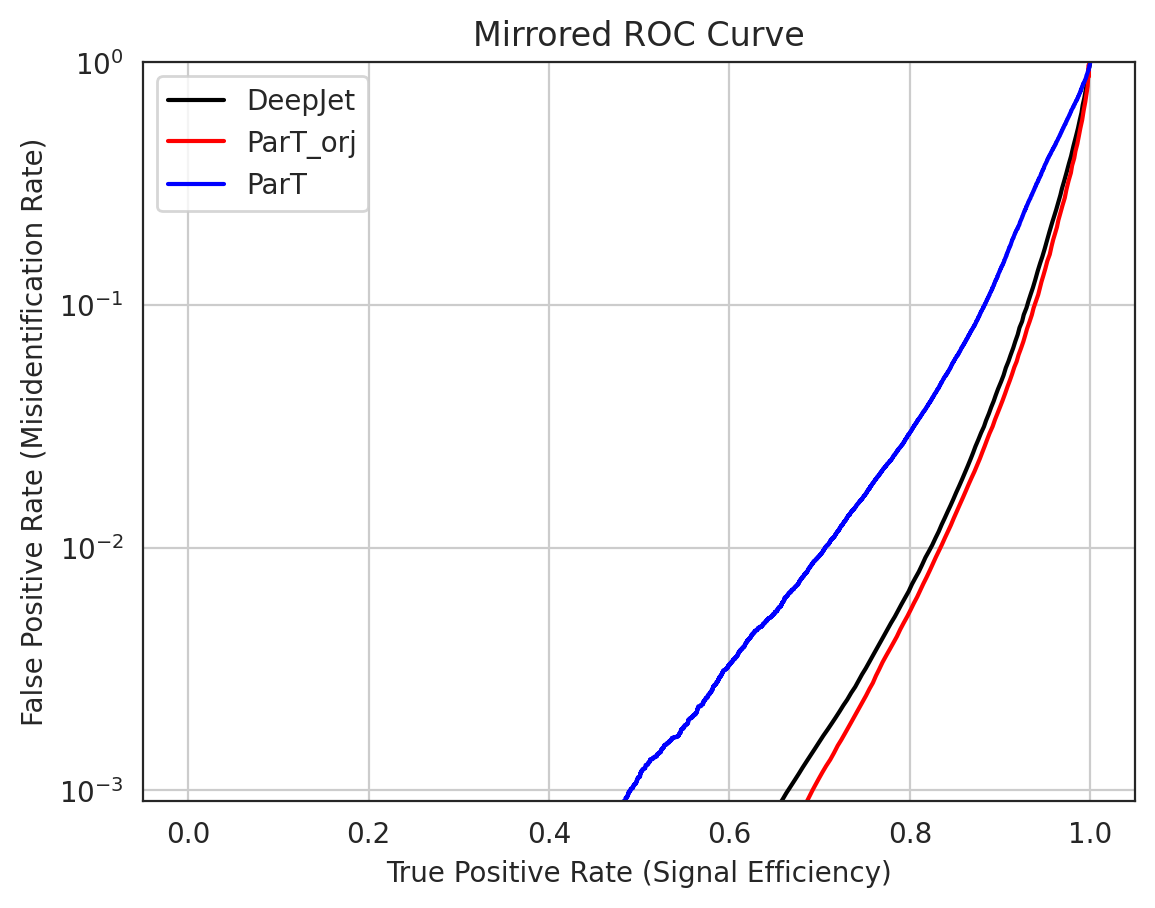

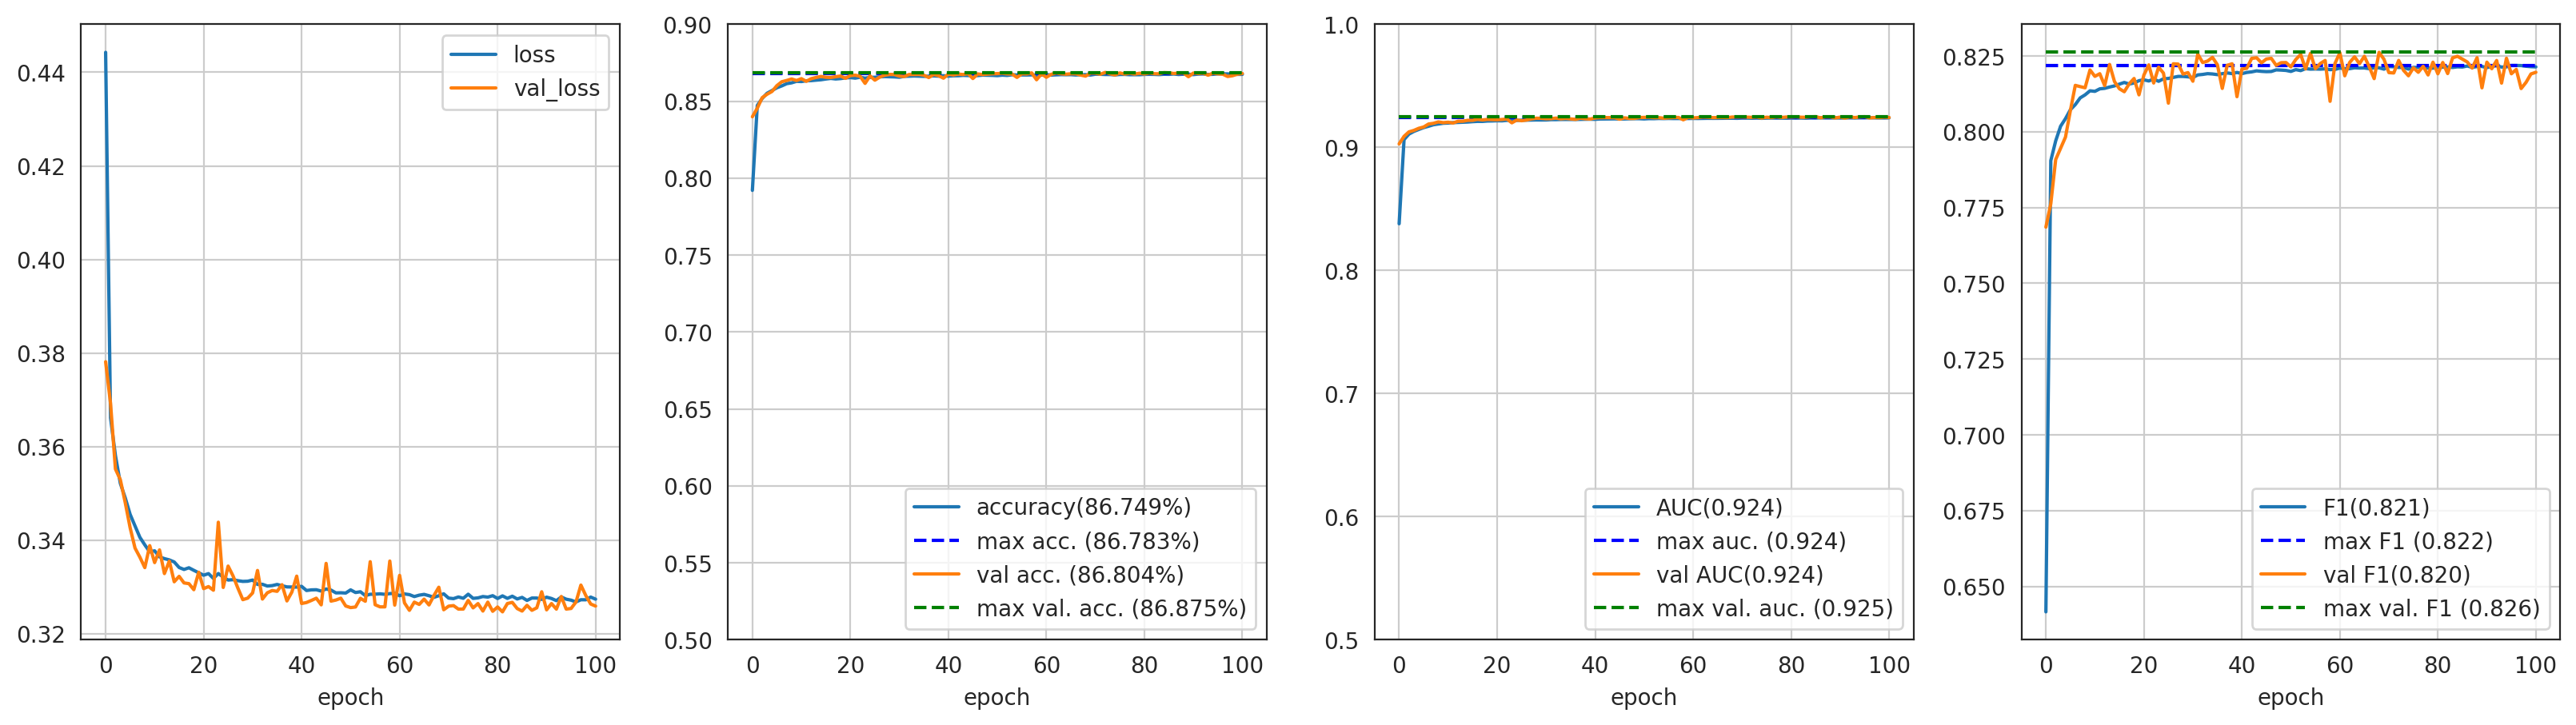

Training: Epoch [101/101] --- Loss: 0.3274 --- Accuracy: 0.8675 --- AUC: 0.924
Test    : Epoch [101/101] --- Loss: 0.3259 --- Accuracy: 0.8680 --- AUC: 0.924


In [8]:

acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)


model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []




    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_particle_inputs, batch_labels, _ in tqdm(train_dataloader): 

        particle_inputs = batch_particle_inputs.transpose(1,2)#.to(device)
        train_label = batch_labels#.to(device)

        optimizer.zero_grad()
        train_pred = model(particle_inputs, states=None)
        train_pred = train_pred.squeeze()
      
        loss = criterion(train_pred, train_label)

        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())

   
    
    #scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_particle_inputs, val_labels, flavors in test_dataloader: 

            val_particle_inputs = val_particle_inputs.transpose(1,2)
            val_preds = model(val_particle_inputs, states=None)
            val_preds = val_preds.squeeze()

            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())
        
            _, _, l_fpr, l_tpr = calculate_rocs(val_preds, val_labels, flavors)
       
    plot_ROC( l_fpr.cpu().numpy(),l_tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_{i_epoch}')

    epoch_val_loss.append(sum(val_losses) / len(val_losses))
    epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
    epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
    epoch_val_f1.append(sum(val_f1s) / len(val_f1s))
             
    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))
 
    plot_metrics(np.arange(i_epoch+epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch+epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch +epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')
    
    torch.cuda.empty_cache()
    del loss, val_loss, train_pred, val_preds
    del train_losses, train_accuracies, train_aucs, train_f1s, val_losses, val_accuracies, val_aucs, val_f1s
    gc.collect()

#keys = ['train_losses', 'train_accuracies', 'train_aucs', 'val_losses', 'val_accuracies', 'val_aucs']
#values = [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs]
#dict_metrics = {keys[i]: values[i] for i in range(len(keys))}

In [9]:
# Save model checkpoint
checkpoint = {
    'epoch': i_epoch + epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': epoch_train_loss,
    'train_accuracies': epoch_train_accuracy,
    'train_aucs': epoch_train_auc,
    'train_f1s': epoch_train_f1,
    'val_losses': epoch_val_loss,
    'val_accuracies': epoch_val_accuracy,
    'val_aucs': epoch_val_auc,
    'val_f1s': epoch_val_f1,

}

checkpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_{i_epoch+epoch+1}.pth'
torch.save(checkpoint, checkpoint_path)


In [10]:
print(i_epoch+epoch+1)

101


In [11]:
# Save model checkpoint
"""
checkpoint = {
    'epoch': i_epoch + epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': epoch_train_loss,
    'train_accuracies': epoch_train_accuracy,
    'train_aucs': epoch_train_auc,
    'train_f1s': epoch_train_f1,
    'val_losses': epoch_val_loss,
    'val_accuracies': epoch_val_accuracy,
    'val_aucs': epoch_val_auc,
    'val_f1s': epoch_val_f1,
    'scaler_mean': scaler.mean_,
    'scaler_std': scaler.scale_,

}

checkpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_{i_epoch+epoch+1}.pth'
torch.save(checkpoint, checkpoint_path)
"""


"\ncheckpoint = {\n    'epoch': i_epoch + epoch + 1,\n    'model_state_dict': model.state_dict(),\n    'optimizer_state_dict': optimizer.state_dict(),\n    'train_losses': epoch_train_loss,\n    'train_accuracies': epoch_train_accuracy,\n    'train_aucs': epoch_train_auc,\n    'train_f1s': epoch_train_f1,\n    'val_losses': epoch_val_loss,\n    'val_accuracies': epoch_val_accuracy,\n    'val_aucs': epoch_val_auc,\n    'val_f1s': epoch_val_f1,\n    'scaler_mean': scaler.mean_,\n    'scaler_std': scaler.scale_,\n\n}\n\ncheckpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_{i_epoch+epoch+1}.pth'\ntorch.save(checkpoint, checkpoint_path)\n"

In [12]:
column_names = ['tpr', 'fpr']
pr = pd.DataFrame({'tpr': l_tpr.cpu(), 'fpr': l_fpr.cpu()})

# Define the file path for saving
output_path = '/home/asugu/work/benchmark/ltc_bench.csv'

# Save the DataFrame to a CSV file with specified column names
pr.to_csv(output_path, index=False)


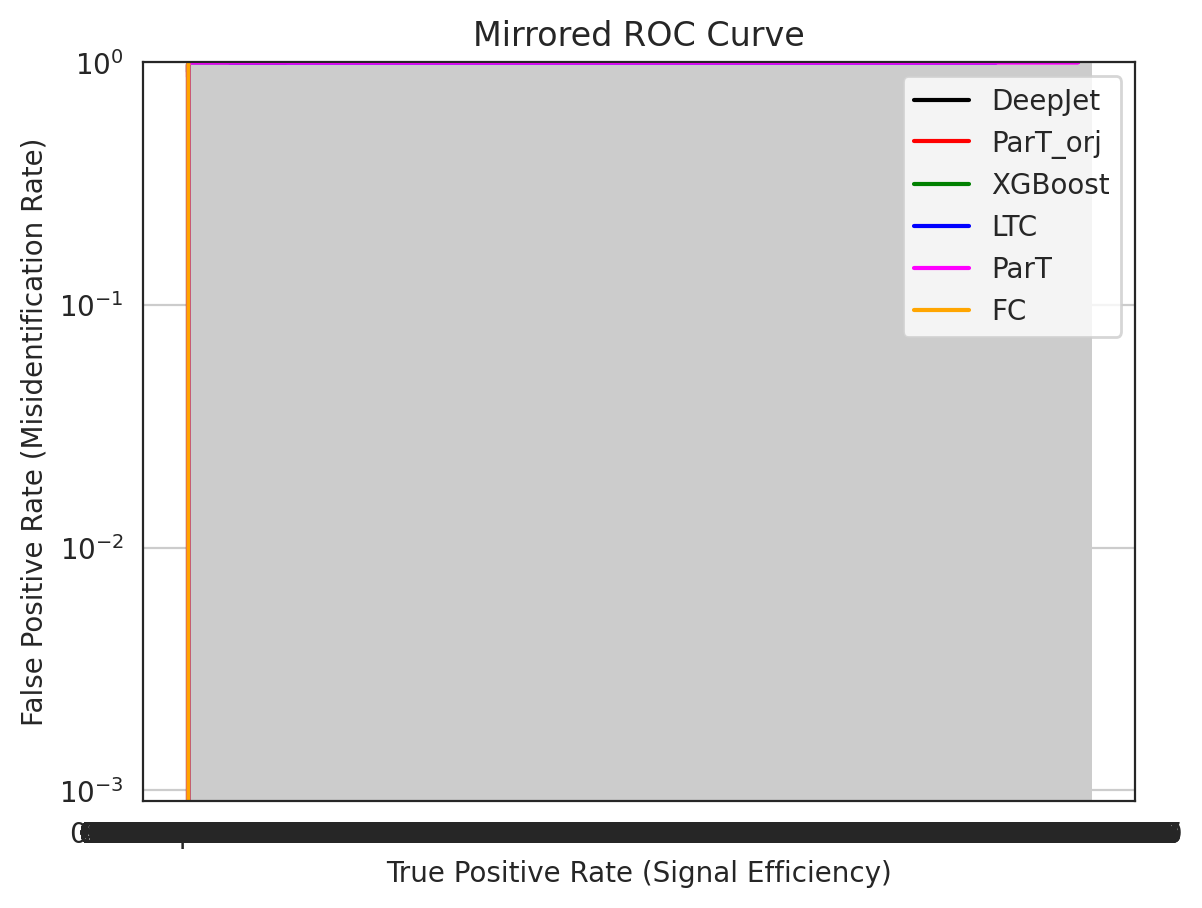

In [13]:
plot_ROC_all()